In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import glob as glb
import os
from PIL import Image
from matplotlib.colors import LinearSegmentedColormap

In [222]:
SYMMETRY = {
    "FM-3M" : [[1,1,1],[2,0,0],[2,2,0],[3,1,1],[2,2,2],[4,0,0],[3,3,1],[4,2,0],[5,1,1],[4,4,0],[5,3,1],[6,0,0],[6,2,0],[5,3,3],[6,2,2],[4,4,4],[7,1,1],[6,4,0],[6,4,2],[7,3,1]],
    "CUSTOM" : [[1,0,2],[1,1,-1],[1,1,1]] #Define a custom symmetry. Ex: [[1, 1, 1], [2, 0, 0]]. This associates [111] with peak 1 (pos0) and [200] with peak 2 (pos1).
}
MATERIALS = {
#    "Bi (I)" : [["pos0"],[4.5470, 4.5470, 11.8571, 36.0], [[1,0,2]]],
#    "Bi (II)" : [["pos1","pos2"],[6.6726, 6.1108, 3.3001, 36.0], [[1,1,-1],[2,0,-1]]],
#    "Cu" : [["pos3"],[3.6150, 3.6150, 3.6150, 140.0], [[2,0,0]]],

    "Bi (I)" : [["pos0"],[4.5470, 4.5470, 11.8571, 36.0], [[1,0,2]]],
    "Bi (II)" : [["pos1"],[6.6726, 6.1108, 3.3001, 36.0], [[1,1,-1]]],
    "Cu" : [["pos2"],[3.6150, 3.6150, 3.6150, 140.0], [[1,1,1]]],

#    "Bi (II)" : [["pos1","pos2"],[3.8, 3.8, 3.8, 36.0], [[1,1,-1],[2,0,1]]],
#    "Bi (I)" : [["pos0"],[4.5470, 4.5470, 11.8571, 36.0], [[1,0,2]]],
#    "Cu" : [["pos3"],[3.6150, 3.6150, 3.6150, 140.0], [[1,1,1],[2,0,0]]],

}
USER_PARAMS = {
    "EXPERIMENT TIME" : 100, #The total amount of time the experiment takes place over (used to calculate time resolution) if exporting pressure vs time plot
    "XRAY WAVELENGTH" : 0.4133, #Wavelength of XRAY in Angstroms
    "SYMMETRY" : "CUSTOM", #What crystal system the material is (used to calculate lattice parameter)
    "HEATMAP DIM" : -1, #Size of X axis for heatmap. The Y dimension is automatically calculated by dividing total size of data set by X. Set this to -1 if the image is square.
    "INVALIDATE HEATMAP NEGATIVES": False, #Toggles if negative values in the heatmap are to be erased (replaces the pixel with a white square).
    "XDI MASK" : True, #Toggles the image mask, "mask.png" for XDI outputs 
    "FWHM THRESHOLD" : [0, 5], #Threshold at which to invalidate FWHM values, set any to -1 to disable.
    "INTENSITY THRESHOLD" : [0, 30], #Threshold at which to invalidate intensity values, set any to -1 to disable.
    "PRESSURE THRESHOLD" : [0, 12], #Threshold at which to invalidate pressure values, set any to -1 to disable.
    "LINE MASK": [5,40], #Region to plot in a Line plot (Excludes gaskets)
    "LINE STEP SIZE" : [0.6] #Step size per data sequence for line graphs (um)
}


In [223]:
def conv_xy(xdim,array,output_path):
    ydim = np.floor(array.size/xdim).astype(int)
    output = []
    for i in range(0, ydim):
        output.append([])
        for j in range (0, xdim):

            #This invalidates negative values. Can be toggled by setting 'INVALIDATE HEATMAP NEGATIVES' in user params.
            value = array[i * xdim + j]
            if value < 0 and USER_PARAMS['INVALIDATE HEATMAP NEGATIVES']:
                value = np.nan

            #Invalidates masked values
            if USER_PARAMS["XDI MASK"]:
                if mask[i][j][3] > 0:
                    value = np.nan

            #Caps XDI values that exceed the threshold
            if not -1 in USER_PARAMS["INTENSITY THRESHOLD"]:
                thresholds = USER_PARAMS["INTENSITY THRESHOLD"]
                value = max(min(value, max(thresholds)), min(thresholds))
            output[i].append(value)
    return output

#This finds the key from a dictionary given a unique value
def findkey(search_value, dictionary):
    for key, value in dictionary.items():
        for sublist in value:
            if search_value in sublist:
                return key
            
#This makes a new path if one doesn't exist
def newpath(filepath):
    if not os.path.exists(filepath):
        os.makedirs(filepath)

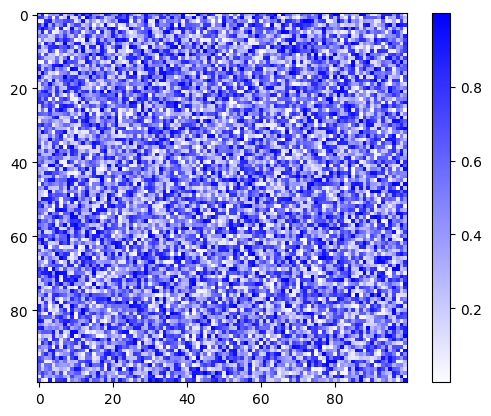

In [224]:
colors = [(1,0,0,c) for c in np.linspace(0.01,1,256)]
cmapred = LinearSegmentedColormap.from_list('mycmap', colors, N=256)
colors = [(0,0,1,c) for c in np.linspace(0.01,1,256)]
cmapblue = LinearSegmentedColormap.from_list('mycmap', colors, N=256)

f,ax = plt.subplots()
h = ax.imshow(np.random.rand(100,100),cmap=cmapblue)
plt.colorbar(mappable=h)

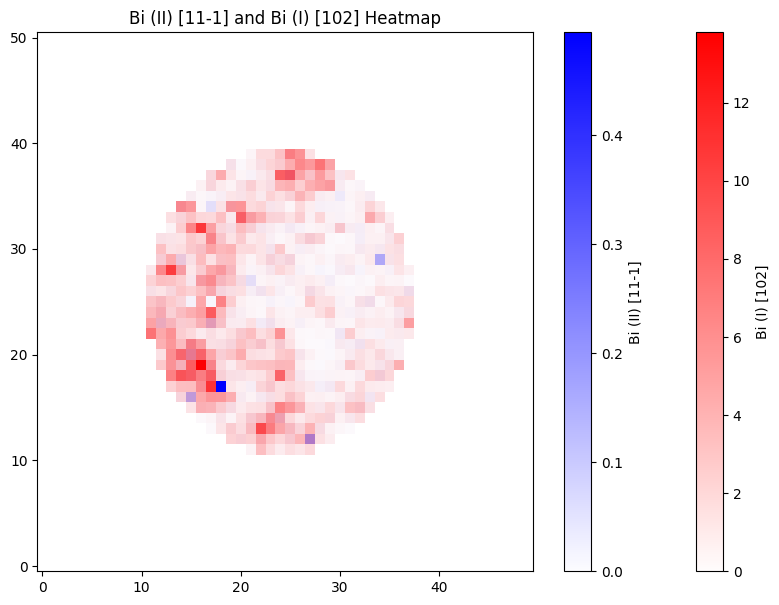

In [225]:
file = glb.glob("./inputs/XDI/*.csv")[0]

peaklist = []

for material in MATERIALS.keys():
    for peak in MATERIALS[material][0]:
        peaklist.append(peak)

output_path = "X:/APS trips/s16bmd-20221027-e263438-Park-Devaraj/CuBi4LP/Data analysis/Andrew/outputs/XDI/Bi/"
crystaldf = pd.read_csv(file)
crystaldf.head()

plt.rcParams['axes.facecolor'] = 'white'
mask = np.array(Image.open("mask.png"))
data = crystaldf['int0']
data2 = crystaldf['int1']

if False:
    data2 = np.zeros(len(data))
    
fig = plt.figure(figsize=(10,7))
plt.title("Bi (II) [11-1] and Bi (I) [102] Heatmap")

scale = max(max(data), max(data2)) if max(max(data), max(data2)) <= max(USER_PARAMS["INTENSITY THRESHOLD"]) else max(USER_PARAMS["INTENSITY THRESHOLD"])

xdim = np.floor(np.sqrt(data.size)).astype(int)
Z = conv_xy(xdim, data, output_path)
X = np.arange(np.array(Z).shape[1])
Y = np.arange(np.array(Z).shape[0])
c = plt.pcolormesh(X,Y,Z, cmap=cmapred, vmin=0, #vmax=scale
                   )
plt.colorbar(c, label="Bi (I) [102]")

xdim = np.floor(np.sqrt(data2.size)).astype(int)
Z = conv_xy(xdim, data2, output_path)
X = np.arange(np.array(Z).shape[1])
Y = np.arange(np.array(Z).shape[0])
c = plt.pcolormesh(X,Y,Z, cmap=cmapblue, vmin=0, #vmax=scale
                   )
plt.colorbar(c, label="Bi (II) [11-1]")

filename = file.split("\\")[-1].split(".")[0]+".png"

plt.savefig(output_path+filename)